# Blood Donation challenge

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

## Get data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data

--2019-09-10 22:46:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12843 (13K) [application/x-httpd-php]
Saving to: ‘transfusion.data’

transfusion.data    100%[===================>]  12,54K  --.-KB/s    in 0s      

2019-09-10 22:46:11 (200 MB/s) - ‘transfusion.data’ saved [12843/12843]



In [3]:
!ls

ml_blood_transfusions_full.ipynb  README.md  transfusion.data


In [4]:
column_names = ["Recency", "Frequency", "Amount", "Times", "Donation"]
data = pd.read_csv("transfusion.data", names=column_names, header=0)
data.head()

,Recency,Frequency,Amount,Times,Donation
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## EDA

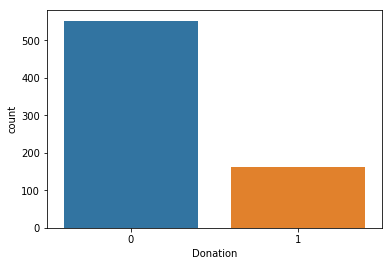

In [15]:
sns.countplot(x=data['Donation'])

/home/bponiecki/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/bponiecki/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/bponiecki/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/bponiecki/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, *

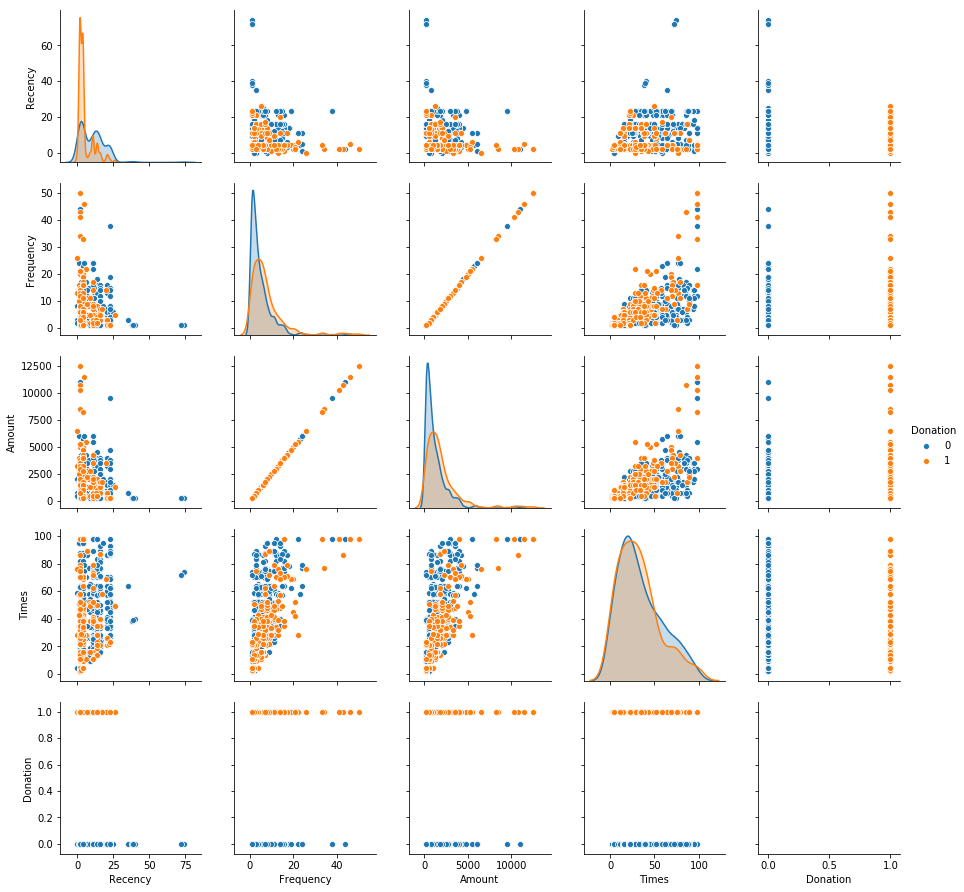

In [6]:
sns.pairplot(data, hue='Donation')

## Outliners

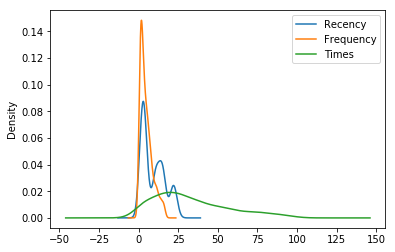

In [7]:
columns = ['Recency', 'Frequency', 'Times']
remove_idx = []
outliner_min_factor = 1.8
outliner_max_factor = 1.8
for col in columns:
    series_desc = data.describe()[col]
    iqr = series_desc['75%']-series_desc['25%']
    outliner_min = series_desc['25%']-(iqr*outliner_min_factor)
    outliner_max = series_desc['75%']+(iqr*outliner_max_factor)
    remove_idx.append(data[data[col]<outliner_min].index.tolist())
    remove_idx.append(data[data[col]>outliner_max].index.tolist())

[data.drop(idx, inplace=True) for idx in remove_idx]
data.reset_index(inplace=True, drop=True)

data[columns].plot.kde()

In [8]:
features = data[columns]
target = data['Donation']

## Distribution fixing

In [9]:
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer

In [32]:
features_transformed = features.values

In [33]:
binning_transformer = KBinsDiscretizer(n_bins=10, encode='ordinal')
binning = binning_transformer.fit_transform(features_transformed)
features_transformed[:,0] = binning[:,0]

In [34]:
power_transformer = PowerTransformer(standardize=False)
features_transformed = power_transformer.fit_transform(features_transformed)

In [35]:
df_features_transformed = pd.DataFrame(features_transformed, columns=['Recency', 'Frequency', 'Times'])

## Oversampling

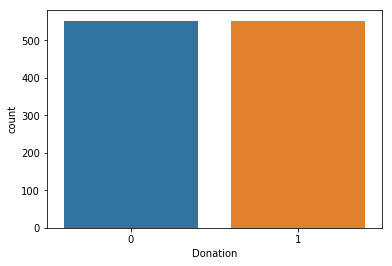

In [36]:
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=42, k_neighbors=5)
df_features_transformed, y_over_sampled = over_sampling.fit_resample(df_features_transformed, target)
sns.countplot(x='Donation', data=pd.DataFrame(y_over_sampled, columns=['Donation']));

## Clean data output

In [37]:
output_data = np.column_stack((df_features_transformed, y_over_sampled))
output = pd.DataFrame(output_data, columns=['Recency', 'Frequency', 'Times', 'Donation'])
output.head()

,Recency,Frequency,Times,Donation
0,0.000000,2.137547,7.095816,1.0
1,0.000000,2.260914,7.960593,1.0
2,2.966527,1.412639,2.256640,0.0
3,1.649377,1.758923,4.875792,1.0
4,0.000000,2.089401,7.960593,0.0


## Model - XGBoost

In [38]:
x = output.drop('Donation', axis=1)
y = output.Donation

In [39]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

In [26]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

params_model1 = {
    'booster': ['dart', 'gbtree'],
    'min_child_weight': [1,5,10,15,20],
    'gamma': [0, 0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 5, 8, 10],
    'max_delta_step': [0, 1, 2, 10],
    'base_score': [0.4, 0.45, 0.5, 0.55, 0.6],
    'reg_alpha':[0, 0.5, 1, 1.5, 2],
    'reg_lambda': [0, 0.5, 1, 1.5, 2]
}

model1 = XGBClassifier(n_estimators=1000, learning_rate=0.01, subsample=0.8, 
                      gamma=0, max_depth=4, colsample_bytree=1, )
rs_model1 = RandomizedSearchCV(model1, param_distributions=params_model1, n_iter=30, 
                               scoring='roc_auc', n_jobs=4, cv=skf.split(x,y), verbose=3, random_state=1001 )
rs_model1.fit(x,y)

rs_model1.best_score_, rs_model1.best_params_ 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.3min finished


(0.8586808837429111,
 {'subsample': 0.6,
  'reg_lambda': 0.5,
  'reg_alpha': 0.5,
  'min_child_weight': 1,
  'max_depth': 5,
  'max_delta_step': 0,
  'gamma': 0,
  'colsample_bytree': 0.8,
  'booster': 'gbtree',
  'base_score': 0.5})

## AutoML - H2O

In [27]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /home/bponiecki/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpojegrp72
  JVM stdout: /tmp/tmpojegrp72/h2o_bponiecki_started_from_python.out
  JVM stderr: /tmp/tmpojegrp72/h2o_bponiecki_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Warsaw
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_bponiecki_el3fnm
H2O cluster total nodes:,1
H2O cluster free memory:,15.70 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


In [44]:
h2o_data = h2o.H2OFrame(output)
h2o_data[3] = h2o_data[3].asfactor()
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(y = 3, training_frame = h2o_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [43]:
lb = aml.leaderboard
lb

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190910_230007,0.893457,0.413325,0.185688,0.362208,0.131195
StackedEnsemble_AllModels_AutoML_20190910_230007,0.892077,0.413449,0.182065,0.362926,0.131715
StackedEnsemble_BestOfFamily_AutoML_20190910_230007,0.892056,0.413211,0.182065,0.362791,0.131617
XGBoost_grid_1_AutoML_20190910_230007_model_2,0.888313,0.416436,0.197464,0.36613,0.134051
GBM_4_AutoML_20190910_230007,0.881428,0.430561,0.224638,0.373948,0.139837
DRF_1_AutoML_20190910_230007,0.878779,0.437803,0.201993,0.375366,0.1409
GBM_3_AutoML_20190910_230007,0.87723,0.438929,0.207428,0.377332,0.142379
GBM_2_AutoML_20190910_230007,0.874183,0.445831,0.248188,0.380275,0.144609
XRT_1_AutoML_20190910_230007,0.873799,0.44772,0.206522,0.379317,0.143881
GBM_grid_1_AutoML_20190910_230007_model_2,0.871579,0.500847,0.221014,0.387732,0.150336


In [46]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190910_230530


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,74.0,74.0,38551.0,6.0,6.0,6.0,11.0,54.0,36.824326




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08471743164584478
RMSE: 0.2910625905983879
LogLoss: 0.2855358825479379
Mean Per-Class Error: 0.1159420289855072
AUC: 0.9593786100609116
pr_auc: 0.9633204505898346
Gini: 0.9187572201218233

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4609569821547311: 

,,0,1,Error,Rate
0,0,471.0,81.0,0.1467,(81.0/552.0)
1,1,52.0,500.0,0.0942,(52.0/552.0)
2,Total,523.0,581.0,0.1205,(133.0/1104.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.460957,0.882613,207.0
1,max f2,0.282286,0.921414,254.0
2,max f0point5,0.576792,0.922517,177.0
3,max accuracy,0.537907,0.884058,186.0
4,max precision,0.996151,1.000000,0.0
5,max recall,0.053742,1.000000,363.0
6,max specificity,0.996151,1.000000,0.0
7,max absolute_mcc,0.537907,0.769253,186.0
8,max min_per_class_accuracy,0.507112,0.876812,194.0
9,max mean_per_class_accuracy,0.537907,0.884058,186.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.02 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010870,0.976630,2.000000,2.000000,1.000000,0.983403,1.000000,0.983403,0.021739,0.021739,100.000000,100.000000
1,,2,0.020833,0.975673,2.000000,2.000000,1.000000,0.976089,1.000000,0.979905,0.019928,0.041667,100.000000,100.000000
2,,3,0.030797,0.969301,2.000000,2.000000,1.000000,0.971346,1.000000,0.977136,0.019928,0.061594,100.000000,100.000000
3,,4,0.041667,0.965795,2.000000,2.000000,1.000000,0.967023,1.000000,0.974498,0.021739,0.083333,100.000000,100.000000
4,,5,0.050725,0.960439,2.000000,2.000000,1.000000,0.962763,1.000000,0.972402,0.018116,0.101449,100.000000,100.000000
5,,6,0.101449,0.947243,2.000000,2.000000,1.000000,0.952648,1.000000,0.962525,0.101449,0.202899,100.000000,100.000000
6,,7,0.150362,0.934125,2.000000,2.000000,1.000000,0.940244,1.000000,0.955277,0.097826,0.300725,100.000000,100.000000
7,,8,0.200181,0.917578,2.000000,2.000000,1.000000,0.925671,1.000000,0.947909,0.099638,0.400362,100.000000,100.000000
8,,9,0.299819,0.853826,2.000000,2.000000,1.000000,0.890685,1.000000,0.928892,0.199275,0.599638,100.000000,100.000000
9,,10,0.400362,0.594661,1.747748,1.936652,0.873874,0.749695,0.968326,0.883890,0.175725,0.775362,74.774775,93.665158




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13119470098008304
RMSE: 0.36220809071593507
LogLoss: 0.4133246756188957
Mean Per-Class Error: 0.18568840579710144
AUC: 0.893457256878807
pr_auc: 0.9039755289571532
Gini: 0.7869145137576139

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4440280935584466: 

,,0,1,Error,Rate
0,0,438.0,114.0,0.2065,(114.0/552.0)
1,1,91.0,461.0,0.1649,(91.0/552.0)
2,Total,529.0,575.0,0.1857,(205.0/1104.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.444028,0.818101,215.0
1,max f2,0.249596,0.873392,282.0
2,max f0point5,0.637053,0.841743,155.0
3,max accuracy,0.487941,0.814312,204.0
4,max precision,0.991608,1.000000,0.0
5,max recall,0.012260,1.000000,397.0
6,max specificity,0.991608,1.000000,0.0
7,max absolute_mcc,0.444028,0.629170,215.0
8,max min_per_class_accuracy,0.493800,0.809783,202.0
9,max mean_per_class_accuracy,0.487941,0.814312,204.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 48.84 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010870,0.978361,2.000000,2.000000,1.000000,0.985110,1.000000,0.985110,0.021739,0.021739,100.000000,100.000000
1,,2,0.020833,0.971435,2.000000,2.000000,1.000000,0.974573,1.000000,0.980071,0.019928,0.041667,100.000000,100.000000
2,,3,0.030797,0.968336,2.000000,2.000000,1.000000,0.969834,1.000000,0.976759,0.019928,0.061594,100.000000,100.000000
3,,4,0.040761,0.963765,2.000000,2.000000,1.000000,0.965771,1.000000,0.974073,0.019928,0.081522,100.000000,100.000000
4,,5,0.050725,0.957619,2.000000,2.000000,1.000000,0.959547,1.000000,0.971219,0.019928,0.101449,100.000000,100.000000
5,,6,0.100543,0.936729,1.963636,1.981982,0.981818,0.947114,0.990991,0.959275,0.097826,0.199275,96.363636,98.198198
6,,7,0.150362,0.910199,1.963636,1.975904,0.981818,0.924049,0.987952,0.947604,0.097826,0.297101,96.363636,97.590361
7,,8,0.200181,0.883923,1.927273,1.963801,0.963636,0.897841,0.981900,0.935219,0.096014,0.393116,92.727273,96.380090
8,,9,0.299819,0.770432,1.709091,1.879154,0.854545,0.839385,0.939577,0.903371,0.170290,0.563406,70.909091,87.915408
9,,10,0.401268,0.578205,1.357143,1.747178,0.678571,0.674060,0.873589,0.845396,0.137681,0.701087,35.714286,74.717833




Cross-Validation Metrics Summary: 

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8197038,0.028749745,0.81447965,0.8371041,0.8280543,0.84615386,0.77272725
1,auc,0.89295626,0.03731789,0.8897215,0.9060092,0.9125287,0.92608696,0.8304348
2,err,0.18029617,0.028749745,0.18552037,0.16289593,0.1719457,0.15384616,0.22727273
3,err_count,39.8,6.26099,41.0,36.0,38.0,34.0,50.0
4,f0point5,0.80957574,0.021953342,0.8037225,0.8201058,0.8039816,0.8396226,0.780446
5,f1,0.82624567,0.024964133,0.82251084,0.8378378,0.8467742,0.8396226,0.7844828
6,f2,0.8442229,0.038033392,0.8421986,0.8563536,0.8943782,0.8396226,0.7885615
7,lift_top_group,2.0020225,0.07257553,1.990991,2.0654206,1.9557523,2.0849056,1.9130435
8,logloss,0.4134222,0.064986445,0.4242958,0.38154915,0.38450637,0.35568476,0.52107483
9,max_per_class_error,0.22120588,0.045911632,0.22727273,0.19298245,0.2777778,0.16037735,0.24761905



Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-09-10 23:05:39,0.248 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.0,0.500000
1,,2019-09-10 23:05:39,0.252 sec,5.0,0.436937,0.572332,0.900438,0.903480,2.0,0.188406
2,,2019-09-10 23:05:39,0.255 sec,10.0,0.402489,0.507444,0.908807,0.912770,2.0,0.179348
3,,2019-09-10 23:05:39,0.259 sec,15.0,0.377247,0.458752,0.918350,0.920921,2.0,0.169384
4,,2019-09-10 23:05:39,0.263 sec,20.0,0.363027,0.430622,0.924773,0.925973,2.0,0.168478
5,,2019-09-10 23:05:39,0.267 sec,25.0,0.347719,0.400262,0.932239,0.935532,2.0,0.158514
6,,2019-09-10 23:05:39,0.271 sec,30.0,0.338968,0.382465,0.936438,0.940384,2.0,0.153080
7,,2019-09-10 23:05:39,0.275 sec,35.0,0.330308,0.365788,0.940757,0.944909,2.0,0.142210
8,,2019-09-10 23:05:39,0.280 sec,40.0,0.321556,0.349182,0.946336,0.950640,2.0,0.138587
9,,2019-09-10 23:05:39,0.285 sec,45.0,0.317436,0.339905,0.947310,0.949849,2.0,0.136775



Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,Frequency,332.381622,1.000000,0.372226
1,Times,298.004150,0.896572,0.333728
2,Recency,262.569977,0.789965,0.294046
